# Определение стоимости автомобилей

В нашем распоряжении исторические данные сервиса по продаже автомобиля.  
Нам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


*Описание данных опущенно в связи с ограничениями на использование данных

## Основные шаги:
+ Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.  
+ Подготовим выборки для обучения моделей.  
+ Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
+ Проанализируем время обучения, время предсказания и качество моделей.
+ Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.


## Вступление

In [ ]:
# Importing libraries
# ! pip install phik
# ! pip install catboost
# ! pip install shap
# ! pip install category_encoders

import math
import re
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import phik

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_rows', 50)
cm = sns.dark_palette("purple", as_cmap=True)
plt.style.use('dark_background')

In [ ]:
# Constant for fixing randomness
RANDOM_STATE = 42

## Подготовка данных

In [ ]:
# Writing data to a variable
try:
    auto = pd.read_csv('/datasets/autos.csv')

except:
    auto = pd.read_csv('/content/autos.csv')

In [ ]:
# We will immediately overwrite the data, for reliability
df = auto.copy()

In [ ]:
# data size
df.shape

(354369, 16)

In [ ]:
# Creating a function for calculating losses during preprocessing
original_df = len(df)
def percentage_losses(data):
    removed_rows = original_df - len(data)
    loss_percentage = (1 - (len(df) / original_df)) * 100
    print(f'Процент потерь составил: {loss_percentage:.2f}%')

In [ ]:
# Look at the data
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
# Let's look at the types of signs
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

Столбцы в формате PascalCase переведем на наш привычный змееустский парселтанг ручками

In [ ]:
def pascal_to_snake(name):
    """Changing strings to snake-case"""

    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [ ]:
df = df.rename(columns=lambda x: pascal_to_snake(x))

In [ ]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [ ]:
# Share of passes by features
df.isna().mean().sort_values(ascending=False)

repaired              0.200791
vehicle_type          0.105794
fuel_type             0.092827
gearbox               0.055967
model                 0.055606
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

In [ ]:
# Function for visualizing missing values
def isna_visual(data: pd.DataFrame):
    """Visualize missing values in a DataFrame.

    Args:
        data (pd.DataFrame): The DataFrame to visualize.

    Returns:
        None

    Raises:
        ValueError: If no missing values are found in the DataFrame.
    """

  try:
    (
    (df.isna().mean()*100).to_frame()
            .rename(columns={0: 'col'})
            .query('0 < col')
            .sort_values(by='col')
            .plot(kind='barh', figsize=(14,7),
                  legend=False, color='purple',)
            )
    plt.title('Пропущенные значения' + '\n', fontsize=15)
    plt.xlabel('Процент пропусков', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    plt.show()

  except:
    print(f'\033[31m{"🚨Пропущенных значений не найдено🚨"}\033[0m')

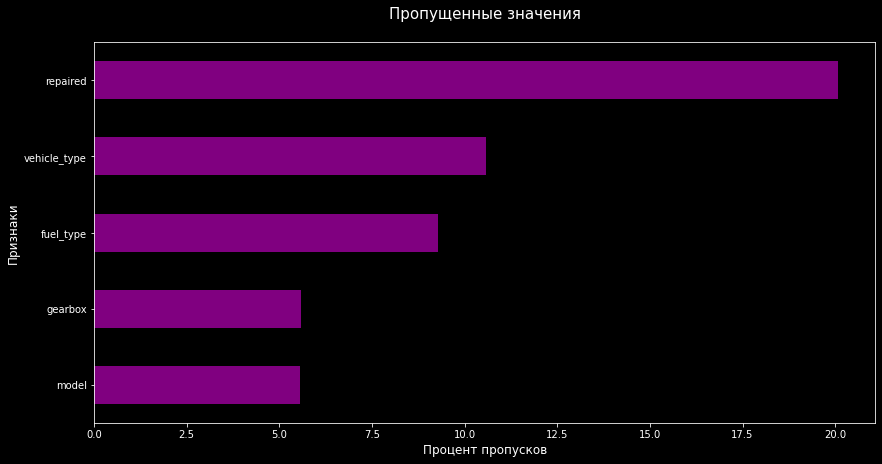

In [ ]:
# Let's look at our passes
isna_visual(df)

In [ ]:
# Complete duplicates in the data
df.duplicated().sum()

4

In [ ]:
# Look at them
df[df.duplicated(keep=False)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Видим, что присутствуют полные дубликаты, устраним их

In [ ]:
# Eliminate complete duplicates and overwrite data
df = df.drop_duplicates()

In [ ]:
# Look at the implicit
df[df.duplicated(subset=['registration_year', 'kilometer', 'model',
                         'brand', 'power', 'postal_code'], keep=False)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21 00:00:00,0,4177,2016-04-06 07:45:42
19,2016-04-01 22:55:47,1850,bus,2004,manual,102,a_klasse,150000,1,petrol,mercedes_benz,no,2016-04-01 00:00:00,0,49565,2016-04-05 22:46:05
20,2016-04-01 19:56:48,10400,coupe,2009,manual,160,scirocco,100000,4,petrol,volkswagen,no,2016-04-01 00:00:00,0,75365,2016-04-05 16:45:49
27,2016-03-07 12:51:23,6900,sedan,2008,manual,99,civic,60000,11,petrol,honda,no,2016-03-07 00:00:00,0,12621,2016-03-26 09:44:53
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354349,2016-03-16 17:06:19,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,2016-03-16 00:00:00,0,56472,2016-03-18 11:30:17
354350,2016-04-02 16:43:27,1400,sedan,2001,manual,125,astra,150000,2,petrol,opel,no,2016-04-02 00:00:00,0,23820,2016-04-06 15:18:04
354352,2016-03-06 21:11:23,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no,2016-03-05 00:00:00,0,60437,2016-03-12 12:18:05
354355,2016-03-21 15:36:22,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no,2016-03-21 00:00:00,0,45896,2016-04-06 15:45:01


Также имеем много неявных

In [ ]:
# Basic statistics
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Сразу в глаза бросается неинформативность признака 'number_of_pictures', так как он имеет всего одно значение

Посмотрим на количество объектов по уникальным значениям категориальных признаков

In [ ]:
def value_show(col: str, value: bool = True, plot: bool = True):
    """Display unique values and optionally plot their distribution.

    Args:
        col (str): The name of the feature to process.
        value (bool, optional): Indicates whether
                    to calculate the count of unique values. Defaults to True.
        plot (bool, optional): Indicates whether
                    to create a distribution plot of unique values. Defaults to True.

    Returns:
        None

    Example:
        >>> value_show('feature_name')
    """
    column = df[col].value_counts()
    if value:
        print(f'Количество уникальных значений признака {col}:\n')
        print(column)
        print()
    if plot:
        column.plot(figsize=(15,5))
        plt.title(f'Количество уникальных значений по признаку {col}', fontsize=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Count', fontsize=12)

In [ ]:
# Number of objects by unique attribute values number of images
value_show('number_of_pictures', plot=False)

Количество уникальных значений признака number_of_pictures:

0    354365
Name: number_of_pictures, dtype: int64



Количество уникальных значений признака brand:

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada            

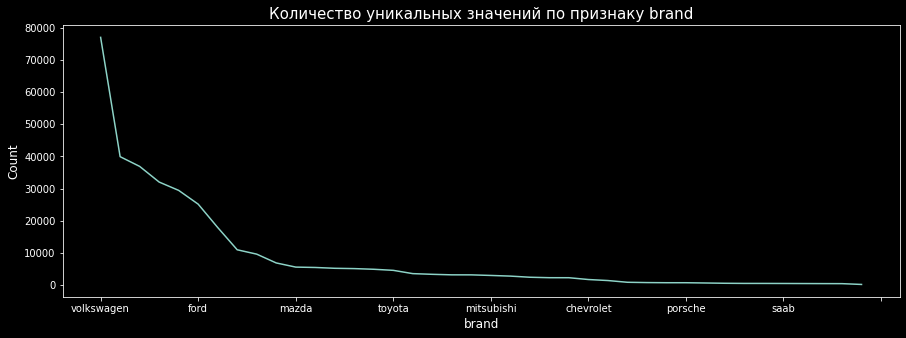

In [ ]:
# Number of objects by unique brand attribute values
value_show('brand')

Количество уникальных значений признака vehicle_type:

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64



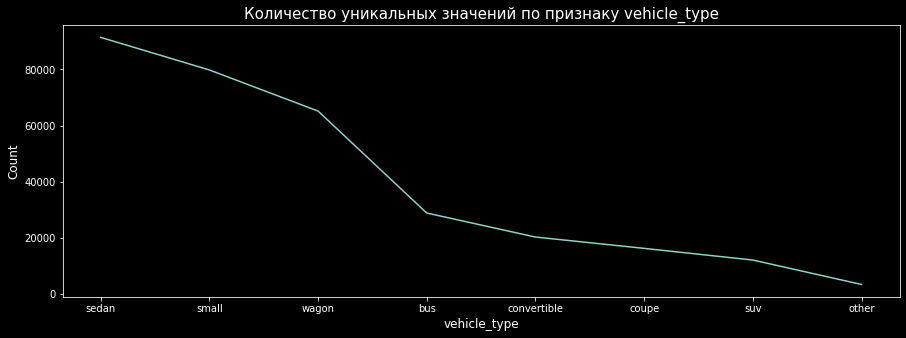

In [ ]:
# Number of objects by unique values of the body type attribute
value_show('vehicle_type')

In [ ]:
# Number of objects by unique values of the gearbox attribute
value_show('gearbox', plot=False)

Количество уникальных значений признака gearbox:

manual    268249
auto       66283
Name: gearbox, dtype: int64



In [ ]:
# Number of objects by unique values of the model attribute
value_show('model', plot=0)

Количество уникальных значений признака model:

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64



Количество уникальных значений признака fuel_type:

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64



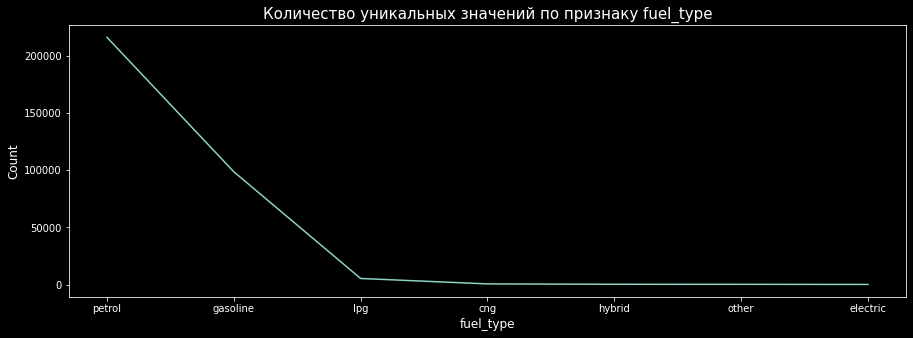

In [ ]:
# Number of objects by unique values of the gearbox attribute
value_show('fuel_type')

Видим, что присутствует два различных значения petrol и gazoline, но означающих одно и тоже, заменим значение gazolinе на petrol, также можно объединить значения lpg и cng, так как это пропан-бутановое и природное газовое топливо, проверим медианное значение цены по этим значениям

In [ ]:
# Function to output the median cost by fuel type
def fuel_median_price(fuel_list: np.ndarray):
    """Calculate the median price for all data and unique feature values.

    Args:
        fuel_list (np.ndarray): Unique feature values from the dataset.

    Returns:
        None

    Prints:
        - Median price for the entire 'price' feature.
        - Median price for the 'price' feature grouped by unique 'fuel_list' values.

    Example:
        >>> fuel_median_price(unique_fuel_values)
    """
    print(f"Медианная цена по всем данным: {df.price.median()}")
    print('-' * 40)
    print('Медианная цена авто по типам топлива:\n')
    for fuel in fuel_list:
        print(f'{fuel}:  {df.query("fuel_type == @fuel")["price"].median()}')

In [ ]:
fuel_median_price(df['fuel_type'].unique())

Медианная цена по всем данным: 2700.0
----------------------------------------
Медианная цена авто по типам топлива:

petrol:  2000.0
gasoline:  5200.0
nan:  nan
lpg:  2983.5
other:  974.5
hybrid:  9990.0
cng:  3650.0
electric:  5799.5


Как мы видим, цены значительно отличаются по анкетам с указанными типами топлива lpg от cng, мы не можем их объединить, но  petrol и gasoline, означают одно и тоже, похоже просто кому как привычнее, так и отмечает, необходимо уточнить у заказчика по этому поводу, есть ли отличия в этих типах, предварительно заменим значения, хоть и цена сильно разнится

In [ ]:
# Replacing the values from the fuel type attribute
df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

Количество уникальных значений признака fuel_type:

petrol      315068
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64



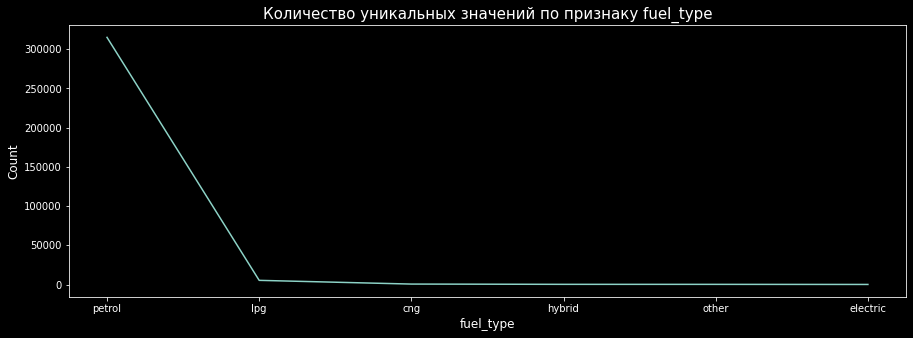

In [ ]:
# Checking
value_show('fuel_type')

In [ ]:
# Number of objects by unique values of the gearbox attribute
value_show('repaired', plot=False)

Количество уникальных значений признака repaired:

no     247158
yes     36053
Name: repaired, dtype: int64



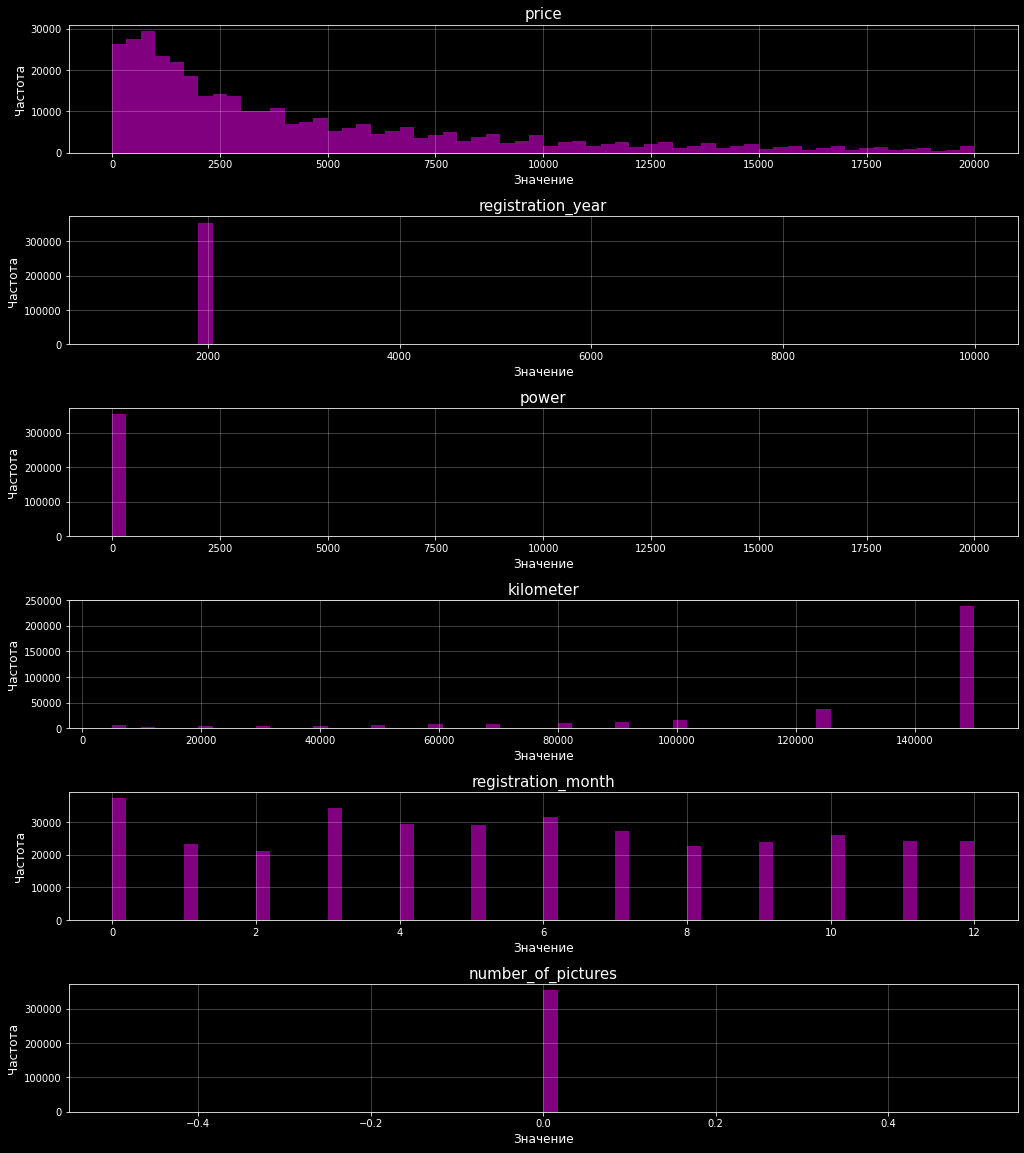

In [ ]:
# Look at the distribution of data
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(17,20))
df.iloc[:,1:-2].hist(ax=axes, bins=60, color='purple')
plt.subplots_adjust(hspace=0.5)
for ax in axes.flatten():
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Значение', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)
    ax.set_title(ax.get_title(), fontsize=15)

Присутствуют жирные хвосты в объектах признаков power и год регистрации, также в цене

In [ ]:
# Look at the values of the month of registration
(
    df['registration_month'].value_counts().to_frame()
                            .style.background_gradient(cmap=cm)
    )

,registration_month
0,37352
3,34373
6,31507
4,29270
5,29153
7,27211
10,26099
12,24289
11,24186
9,23813


Присутствует 13-й месяц в котором больше всего значений, возможно нет информации о месяце регистрации, этот признак не очень информативен, в дальнейшем мы откажемся от него после проверки зависимостей признаков

Посмотрим на год регистрации

In [ ]:
# Sampling by erroneous year of registration
non_year = df.query('registration_year < 1941 or registration_year > 2019')
non_year

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15 00:00:00,0,79288,2016-04-07 05:15:34
6629,2016-04-02 13:47:16,0,small,1910,NaN,0,NaN,5000,1,other,sonstige_autos,NaN,2016-04-02 00:00:00,0,93105,2016-04-04 11:16:30
6977,2016-03-24 08:37:22,135,NaN,1910,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-24 00:00:00,0,19374,2016-04-06 20:46:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343083,2016-04-01 08:51:08,1,other,1910,NaN,0,NaN,5000,1,other,volkswagen,NaN,2016-04-01 00:00:00,0,18273,2016-04-07 05:44:39
348830,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,41472,2016-04-05 14:18:01
351682,2016-03-12 00:57:39,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03-11 00:00:00,0,16515,2016-04-05 19:47:27
353531,2016-03-16 21:56:55,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN,2016-03-16 00:00:00,0,23936,2016-03-30 18:47:41


In [ ]:
# We get an erroneous input in the registration_year attribute
np.sort(non_year['registration_year'].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500,
       3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900,
       5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500,
       8888, 9000, 9229, 9450, 9996, 9999])

In [ ]:
# Number of unique values of the registration year
non_year['registration_year'].value_counts().head(20)

1910    101
1000     37
9999     26
5000     17
1937     11
1938      8
1929      7
3000      7
6000      5
1500      5
1800      5
7000      4
1935      4
1234      4
2500      4
4000      3
1933      3
9000      3
1930      3
1111      3
Name: registration_year, dtype: int64

Есть вопросы по поводу этого признака, год регистрации это когда в первый раз машина была зарегистрирована после выпуска, дата выпуска авто или последний покупатель зарегистрировавший это авто, необходимо уточнить у заказчика

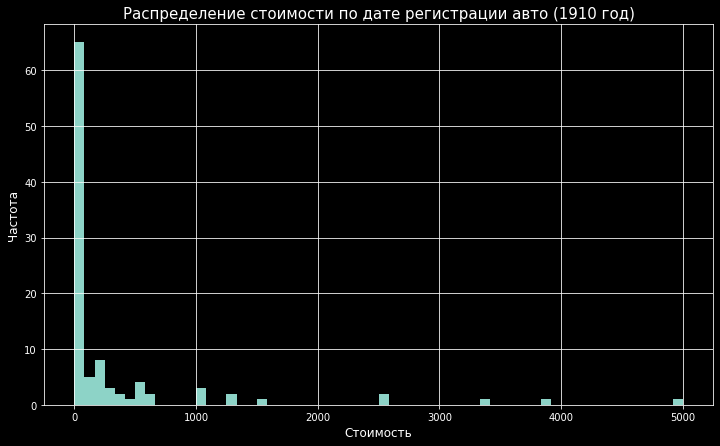

In [ ]:
# Cost distribution by car registration date
(
    non_year.query('registration_year == 1910')['price']
            .hist(bins=60, figsize=(12, 7))
    )
plt.xlabel('Стоимость', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Распределение стоимости по дате регистрации авто (1910 год)', fontsize=15);

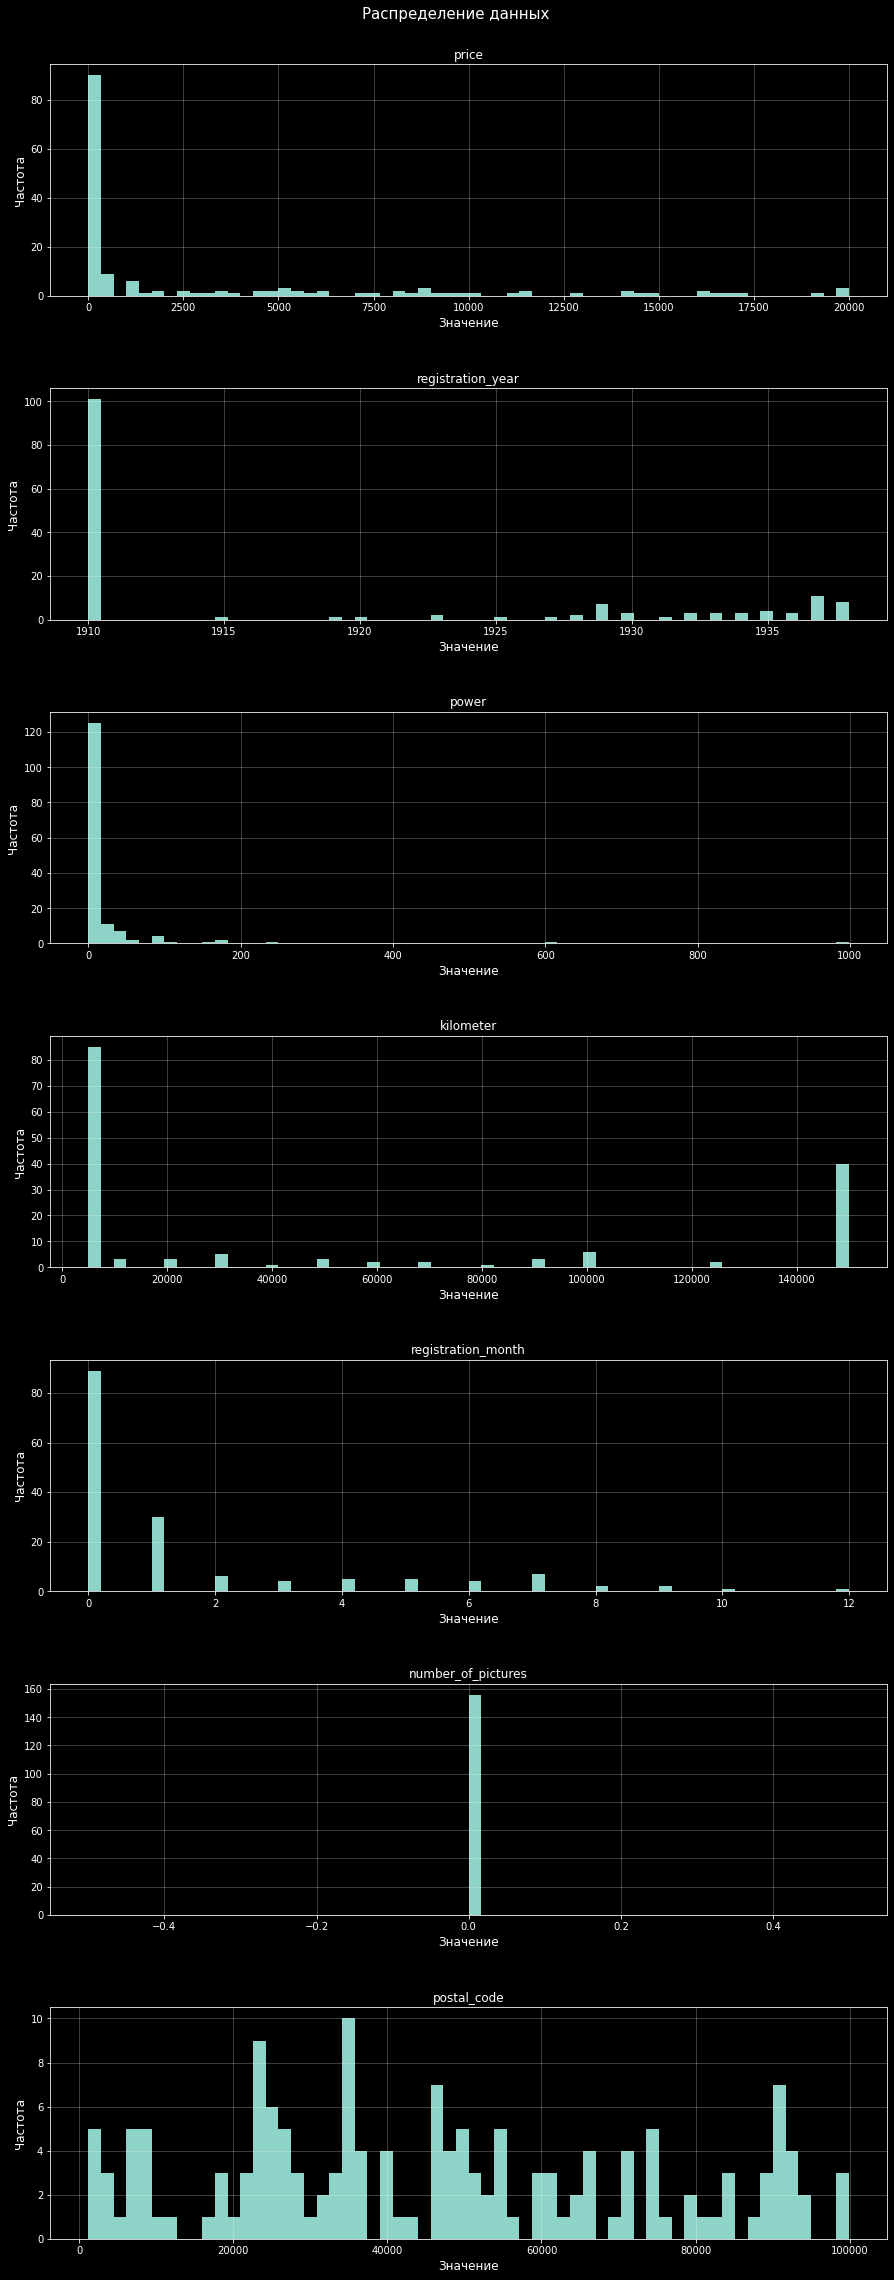

In [ ]:
# Look at the distribution of data
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15,40))
(
    non_year.query('1910 <= registration_year <= 1938')
            .hist(ax=axes, bins=60))
plt.subplots_adjust(hspace=0.4)
for ax in axes.flatten():
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Значение', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)

fig.suptitle('Распределение данных', fontsize=15, y=0.9)

plt.show()

Данные 1910 года - некорректны, выбросы на однотипных значениях

In [ ]:
# An interesting car for only 7 thousand euros
non_year.query('brand == "ford" and registration_year == 1937 and power == 85')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
338109,2016-03-05 17:45:32,7000,coupe,1937,manual,85,other,5000,8,petrol,ford,yes,2016-03-05 00:00:00,0,8359,2016-04-07 10:44:39


<img id='ford' src='https://upload.wikimedia.org/wikipedia/commons/2/26/1937_Ford_V8_Convertible.jpg' width=460, heigth=240>

Рассмотрим поближе более-менее адекватную индексацию признака года регистрации

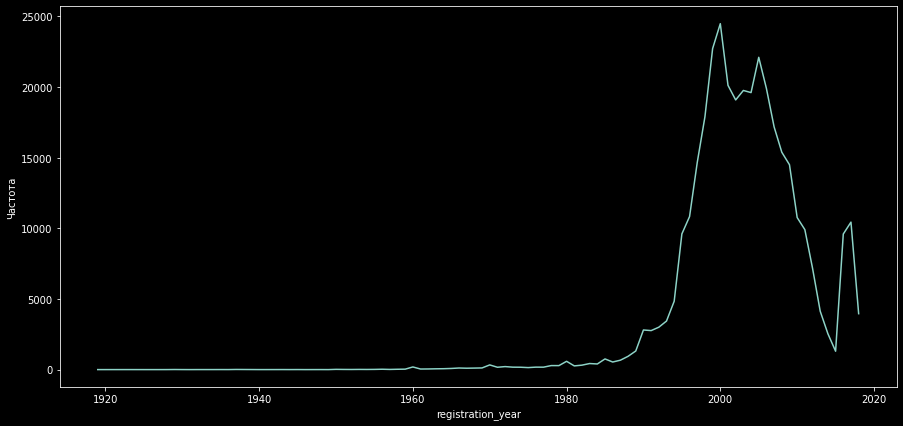

In [ ]:
# Distribution of the sign year of registration from 1915 to 2019
(
    df.query('1915 < registration_year < 2019')
      .groupby('registration_year')['price']
      .count().plot(kind='line', figsize=(15,7)));
plt.ylabel('Частота');

Видим, что у машин заданных по критерию указанного года присутствуют и настоящие машины и ложные объявления в пике указан 1910 год, преобладает минимальная цена и минимальный пробег.  
Также видим, что достаточное количество анкет начинается от 1958-1970, возьмем границу с 1965 года
Теперь необходимо понять имеет ли смысл указанная дата объявлений и можем ли мы порезать данные в верхней границе по этой дате или нет, видим выброс до 2020 года, рассмотрим его поближе

In [ ]:
# Let's bring the signs of dates to the datetime type
date_grouped = ['date_crawled', 'date_created', 'last_seen']

df[date_grouped] = (
                      df[date_grouped].apply(pd.to_datetime,
                                             format='%Y-%m-%dT%H:%M:%S'))

In [ ]:
date_group = (
    df.groupby('date_crawled')['registration_year']
      .count().reset_index()
    )
date_group.head(20)

,date_crawled,registration_year
0,2016-03-05 14:06:22,1
1,2016-03-05 14:06:23,1
2,2016-03-05 14:06:24,3
3,2016-03-05 14:06:25,2
4,2016-03-05 14:06:26,1
5,2016-03-05 14:06:27,2
6,2016-03-05 14:06:28,1
7,2016-03-05 14:06:29,2
8,2016-03-05 14:06:30,2
9,2016-03-05 14:06:40,1


In [ ]:
def check_date(data: pd.DataFrame, columns: list):
    """Print unique years and months from DateTime-like features.

    Args:
        data (pd.DataFrame): The DataFrame to analyze.
        columns (list): A list of feature names to iterate over.

    Returns:
        None

    Prints:
        - Unique years for each specified feature.
        - Unique months for each specified feature.

    Example:
        >>> check_date(data_frame, ['date_column'])
    """
    for col in columns:
        print(f'Уникальный год признака {col}:\n {data[col].dt.year.unique()}')
        print(f'Уникальные месяца признака {col}:\n {data[col].dt.month.unique()}\n')

In [ ]:
# Look at the unique values of date attributes
check_date(df, date_grouped)

Уникальный год признака date_crawled:
 [2016]
Уникальные месяца признака date_crawled:
 [3 4]

Уникальный год признака date_created:
 [2016 2015 2014]
Уникальные месяца признака date_created:
 [ 3  4  2  1 11 12  9  8  6]

Уникальный год признака last_seen:
 [2016]
Уникальные месяца признака last_seen:
 [4 3]



У нас присутствуют наблюдения только до 2016 года, посмотрим на объекты младше 2016 года

In [ ]:
# Objects younger than 2016
after_16 = df.query('2016 < registration_year <= 2020')

after_16['registration_year'].value_counts()

2017    10441
2018     3959
2019       25
Name: registration_year, dtype: int64

In [ ]:
after_16.isna().mean().to_frame().style.background_gradient(cmap=cm)

,0
date_crawled,0.000000
price,0.000000
vehicle_type,0.998614
registration_year,0.000000
gearbox,0.123813
power,0.000000
model,0.138995
kilometer,0.000000
registration_month,0.000000
fuel_type,0.382530


Достаточно много объектов младше 2016 года, почти 100% объектов не имеют значения типа кузова, посмотрим на данные

In [ ]:
after_16.sample(10, random_state=RANDOM_STATE)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
206476,2016-03-14 18:46:04,6799,NaN,2017,manual,170,5er,150000,11,NaN,bmw,NaN,2016-03-14,0,31582,2016-03-15 13:48:33
69732,2016-04-04 13:55:19,3590,NaN,2017,manual,131,passat,150000,6,NaN,volkswagen,no,2016-04-04,0,18209,2016-04-06 15:16:47
156769,2016-03-24 17:56:08,1000,NaN,2017,NaN,0,NaN,150000,0,NaN,opel,NaN,2016-03-24,0,21354,2016-03-24 18:44:45
348566,2016-03-11 03:03:11,1500,NaN,2017,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-11,0,40476,2016-04-06 04:44:37
75523,2016-03-15 08:51:54,500,NaN,2017,manual,58,twingo,150000,11,petrol,renault,NaN,2016-03-15,0,26384,2016-03-15 08:51:54
289071,2016-03-08 17:56:40,0,NaN,2018,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-08,0,50823,2016-03-21 00:46:17
212808,2016-03-07 14:59:53,250,NaN,2017,manual,0,golf,150000,0,NaN,volkswagen,yes,2016-03-07,0,56281,2016-03-20 01:17:16
320678,2016-03-27 20:45:25,1599,NaN,2018,manual,63,getz,125000,5,petrol,hyundai,no,2016-03-27,0,53119,2016-04-01 21:44:42
191445,2016-03-15 17:46:13,2995,NaN,2018,auto,113,c3,100000,1,petrol,citroen,no,2016-03-15,0,99974,2016-03-28 05:44:42
121948,2016-03-19 19:54:15,2790,NaN,2018,manual,0,astra,70000,0,petrol,opel,NaN,2016-03-19,0,30165,2016-03-24 16:18:10


Пока что все машины выглядят вполне адекватно кроме отсутствия типа кузова, кажется что ошибка кроется в дате, так как все даты исключительно 2016 года, а также месяц только третий и четвертый, идентичны данные из признака даты размещения и выгрузки, также дата последнего просмотра намного позже даты выгрузки по этой выборке, хотя в уникальных значениях есть и другие даты

In [ ]:
# Number of objects by year
df['date_created'].dt.year.value_counts()

2016    354339
2015        25
2014         1
Name: date_created, dtype: int64

In [ ]:
# Number of objects by month
df['date_created'].dt.month.value_counts()

3     296756
4      57118
2        397
1         70
11         9
12         9
9          3
8          2
6          1
Name: date_created, dtype: int64

Такая же беда и здесь, отличных значений от даты выгрузки почти нет, сделаем вывод, что на эти признаки опираться не нужно и исключим их в дальнейшем


In [ ]:
# Data for the 2019 registration year
after_16.query('registration_year == 2019')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
30319,2016-03-07 07:36:24,5500,NaN,2019,manual,0,ceed,125000,0,NaN,kia,NaN,2016-03-07,0,65239,2016-03-11 06:44:48
35506,2016-03-31 08:37:04,1200,NaN,2019,manual,140,156,150000,5,petrol,alfa_romeo,no,2016-03-31,0,91058,2016-04-06 03:15:42
37181,2016-03-08 13:52:49,0,NaN,2019,manual,0,transporter,70000,0,NaN,volkswagen,no,2016-03-08,0,20249,2016-03-10 07:44:11
48562,2016-03-07 18:52:22,0,NaN,2019,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-07,0,18510,2016-04-06 13:17:20
50749,2016-03-16 01:37:13,10000,NaN,2019,auto,0,s_klasse,100000,3,cng,mercedes_benz,no,2016-03-16,0,21680,2016-03-16 08:38:57
57074,2016-03-28 11:45:31,1200,NaN,2019,manual,140,156,150000,5,petrol,alfa_romeo,no,2016-03-28,0,91058,2016-04-06 13:45:56
61345,2016-03-12 09:53:33,19490,NaN,2019,NaN,0,i_reihe,30000,4,petrol,hyundai,no,2016-03-12,0,30823,2016-04-06 01:17:28
62809,2016-04-01 16:57:33,2000,NaN,2019,NaN,90,transporter,150000,0,petrol,volkswagen,no,2016-04-01,0,88436,2016-04-01 17:42:04
62996,2016-03-27 12:57:50,7900,NaN,2019,auto,170,passat,150000,12,NaN,volkswagen,no,2016-03-27,0,42103,2016-04-01 12:45:56
74469,2016-04-01 18:42:52,4800,NaN,2019,manual,160,mondeo,150000,0,petrol,ford,NaN,2016-04-01,0,85235,2016-04-03 15:16:36


In [ ]:
# Indexing by 2015 registration year
df.query('registration_year == 2015').isna().mean()

date_crawled          0.000000
price                 0.000000
vehicle_type          0.152074
registration_year     0.000000
gearbox               0.158986
power                 0.000000
model                 0.111367
kilometer             0.000000
registration_month    0.000000
fuel_type             0.161290
brand                 0.000000
repaired              0.199693
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

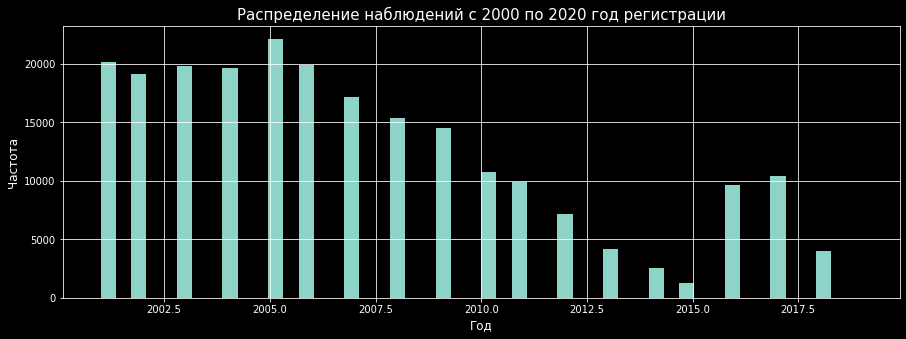

In [ ]:
# Distribution of observations from 2000 to 2020 registration year
(
    df.query('2000 < registration_year < 2020')['registration_year']
      .hist(bins=50, figsize=(15,5)))
plt.xlabel('Год', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Распределение наблюдений с 2000 по 2020 год регистрации', fontsize=15);

При выборочном осмотре видим, что присутствует в выборке 2019 года регистрации alpha romeo 156, который выпускался до 2007 и fiat punto - до 2018, все же не ясно какое значение имеет этот признак, у всех объектов категорически отсутствует тип кузова, также всплеск значений с 2016 года, крайний год в котором 100% отсуствие типа кузова это 2016 год, в 2015 году всего 15%, в 2014 2%, в связи с этим ограничим наши данные по 2015 году - верхняя граница

In [ ]:
# Grouping duplicates
dupl_values = (
    df[df.duplicated(subset=['brand', 'model',
                             'power', 'fuel_type'], keep=False)])
(
    dupl_values.query('brand == "audi" and \
                       model == "80" and \
                       power == 116 and \
                       vehicle_type == "wagon"')
               .sort_values(by=['registration_year', 'price',
                                'date_created', 'postal_code']))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
316772,2016-03-26 16:49:58,249,wagon,1992,manual,116,80,150000,9,petrol,audi,NaN,2016-03-26,0,94267,2016-03-26 16:49:58
121122,2016-03-29 21:55:25,600,wagon,1992,manual,116,80,150000,9,petrol,audi,no,2016-03-29,0,87700,2016-04-06 09:17:35
210026,2016-03-09 18:37:15,800,wagon,1992,manual,116,80,150000,0,petrol,audi,NaN,2016-03-09,0,94527,2016-03-15 05:17:20
149648,2016-03-24 09:52:45,1500,wagon,1992,manual,116,80,150000,12,petrol,audi,no,2016-03-24,0,63826,2016-03-24 10:43:08
105804,2016-03-12 22:36:58,2000,wagon,1992,manual,116,80,150000,12,petrol,audi,no,2016-03-12,0,63826,2016-03-24 02:47:24
21919,2016-03-22 16:57:11,450,wagon,1993,manual,116,80,150000,0,NaN,audi,NaN,2016-03-22,0,86381,2016-03-22 16:57:11
180074,2016-03-23 15:55:31,500,wagon,1993,manual,116,80,150000,3,petrol,audi,yes,2016-03-23,0,57078,2016-04-05 20:16:15
210923,2016-03-14 23:58:10,550,wagon,1993,manual,116,80,150000,0,petrol,audi,NaN,2016-03-14,0,85395,2016-04-05 13:17:09
42561,2016-03-08 20:06:19,600,wagon,1993,manual,116,80,150000,8,petrol,audi,no,2016-03-08,0,56332,2016-03-10 12:34:46
231890,2016-03-15 13:57:31,700,wagon,1993,manual,116,80,150000,0,NaN,audi,no,2016-03-15,0,94527,2016-03-25 06:46:43


Как можно увидеть в этой выборке присутствуют дубликаты объявлений на которых с одного почтового индекса скидывают цены ниже в одном и том же месяце регистрации и выкладки анкеты, также имеют место быть 'перекупщики' и другие компании занимающиеся продажей авто


In [ ]:
# Observations are similar to identical ones,
# the difference in price and 12 days between the creation dates
(
    dupl_values.query('brand == "audi" and \
                       model == "80" and \
                       power == 116 and \
                       vehicle_type == "wagon" and \
                       postal_code == 63826')
               .sort_values(by=['registration_year', 'price',
                                'date_created', 'postal_code'])
               )

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
149648,2016-03-24 09:52:45,1500,wagon,1992,manual,116,80,150000,12,petrol,audi,no,2016-03-24,0,63826,2016-03-24 10:43:08
105804,2016-03-12 22:36:58,2000,wagon,1992,manual,116,80,150000,12,petrol,audi,no,2016-03-12,0,63826,2016-03-24 02:47:24


Похоже сбросили цену по этому авто, в выборке много похожих анкет


In [ ]:
dupl_values.query('postal_code == 63826')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
25246,2016-03-19 13:42:09,2200,coupe,1999,auto,88,3_reihe,80000,6,petrol,mazda,no,2016-03-19,0,63826,2016-03-20 15:17:34
77894,2016-04-02 10:49:48,16990,convertible,2009,manual,177,1er,70000,5,petrol,bmw,no,2016-04-02,0,63826,2016-04-06 08:45:06
101739,2016-03-16 13:50:31,750,small,2003,manual,75,NaN,150000,8,petrol,opel,no,2016-03-16,0,63826,2016-03-20 12:18:17
105804,2016-03-12 22:36:58,2000,wagon,1992,manual,116,80,150000,12,petrol,audi,no,2016-03-12,0,63826,2016-03-24 02:47:24
136207,2016-03-21 16:42:34,10600,NaN,2017,manual,90,twingo,20000,9,NaN,renault,no,2016-03-21,0,63826,2016-04-06 15:45:03
149648,2016-03-24 09:52:45,1500,wagon,1992,manual,116,80,150000,12,petrol,audi,no,2016-03-24,0,63826,2016-03-24 10:43:08
174272,2016-03-31 21:44:52,0,wagon,2004,manual,100,NaN,150000,12,petrol,opel,NaN,2016-03-31,0,63826,2016-04-07 00:15:42
177932,2016-03-26 20:58:31,14800,sedan,2011,manual,163,6_reihe,50000,5,petrol,mazda,no,2016-03-26,0,63826,2016-04-06 12:17:26
185397,2016-03-06 16:53:36,10400,convertible,2010,manual,126,mx_reihe,90000,4,petrol,mazda,no,2016-03-06,0,63826,2016-03-10 00:44:23


In [ ]:
# Number of questionnaires per postal code
df['postal_code'].value_counts().head(20)

10115    819
65428    613
66333    343
32257    317
44145    317
52525    306
26789    296
78224    293
38518    291
13357    290
48599    289
48249    279
60311    276
51065    274
53757    273
52249    268
40764    267
50354    264
60386    262
26871    261
Name: postal_code, dtype: int64

Гипотеза с автодилерами возможно отверглась, 10115 индекс это центральный район Берлина, необходимо уточнить у заказчика


In [ ]:
df[df['postal_code'].map(df['postal_code'].value_counts()) < 10]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
80,2016-04-01 22:39:35,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes,2016-04-01,0,8396,2016-04-05 20:18:14
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
138,2016-04-02 10:59:28,3450,sedan,2007,manual,120,147,150000,4,petrol,alfa_romeo,no,2016-04-02,0,86678,2016-04-04 07:51:11
143,2016-03-14 12:46:46,1500,wagon,1996,manual,126,a4,150000,0,NaN,audi,no,2016-03-14,0,24873,2016-03-17 00:45:29
212,2016-03-11 19:50:22,1200,small,2002,manual,45,lupo,150000,9,petrol,volkswagen,no,2016-03-11,0,38707,2016-03-20 07:18:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354211,2016-03-15 09:53:20,1390,small,2004,manual,60,fiesta,150000,5,petrol,ford,NaN,2016-03-15,0,79862,2016-04-05 19:16:41
354241,2016-03-28 15:48:35,2500,sedan,1999,manual,75,golf,125000,3,petrol,volkswagen,no,2016-03-28,0,98666,2016-04-06 20:46:10
354251,2016-03-12 12:44:17,3300,sedan,2002,manual,75,golf,90000,1,petrol,volkswagen,no,2016-03-12,0,84181,2016-03-21 12:46:24
354266,2016-03-31 16:37:05,399,small,1992,manual,45,polo,150000,4,petrol,volkswagen,NaN,2016-03-31,0,74592,2016-03-31 16:37:05


Всего 9.5 тысяч анкет из всей выборки, с почтового индекса которых, выставлено меньше 10 авто, конечно берем в расчет, что несколько тысяч человек могут проживать по этому почтовому индексу


In [ ]:
# Unique values from the sample based on brand
(
    non_year['brand'].value_counts().to_frame()
                     .head(15).style.background_gradient(cmap=cm))

,brand
sonstige_autos,90
volkswagen,54
opel,35
ford,22
bmw,20
mercedes_benz,17
fiat,11
audi,11
trabant,10
citroen,9


Много наблюдений из этой выборки имеют значение признака 'brand' - другие автомобили

In [ ]:
(
    non_year['price'].value_counts().to_frame()
                  .head(15).style.background_gradient(cmap=cm))

,price
0,84
1,21
500,12
400,8
200,7
1000,6
7999,5
450,5
1500,5
50,5


Много значений равны нулю или аналогичным значениям, можем избавляться от этих данных

In [ ]:
df.shape

(354365, 16)

In [ ]:
# Set a new criterion
non_year = df.query('registration_year < 1965 or registration_year > 2015')
print(f'Уникальные года регистрации вне новых границ:\n {np.sort(non_year["registration_year"].unique())}\n')
non_year.shape

Уникальные года регистрации вне новых границ:
 [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 2016 2017 2018 2019 2066 2200 2222 2290 2500 2800 2900 3000
 3200 3500 3700 3800 4000 4100 4500 4800 5000 5300 5555 5600 5900 5911
 6000 6500 7000 7100 7500 7800 8000 8200 8455 8500 8888 9000 9229 9450
 9996 9999]



(24947, 16)

In [ ]:
# We remove these objects and remove unnecessary variables
df = df.drop(non_year.index)

del after_16, non_year, dupl_values

In [ ]:
# Look at the data
df.shape

(329418, 16)

In [ ]:
percentage_losses(df)

Процент потерь составил: 7.04%


In [ ]:
# Check the correct data
np.sort(df["registration_year"].unique())

array([1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015])

Посмотрим сколько еще присутствует в датафрейме объектов со значением ноль и примерно равные ему в признаке 'price'


In [ ]:
# questionnaires with a cost of less than 100 euros
(
    df[df['price'] < 100]['price'].value_counts()
                                  .to_frame().head(15)
                                  .style.background_gradient(cmap=cm))

,price
0,9241
1,1033
50,293
80,132
99,98
10,81
70,65
60,53
30,49
75,49


Достаточно много плохих анкет машин в базе - убираем

In [ ]:
df = df.drop(df[df['price'] < 100].index)

In [ ]:
# Look at the other cars label
(
    df[df['brand'] == 'sonstige_autos']
                                      .isna().mean()
                                      .sort_values(ascending=False)
                                      .to_frame().head(10)
                                      .style.background_gradient(cmap=cm))

,0
model,1.000000
repaired,0.264055
fuel_type,0.199319
gearbox,0.189949
vehicle_type,0.145656
date_crawled,0.000000
price,0.000000
registration_year,0.000000
power,0.000000
kilometer,0.000000


In [ ]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          10124
registration_year         0
gearbox               13243
power                     0
model                 13767
kilometer                 0
registration_month        0
fuel_type             19599
brand                     0
repaired              54163
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [ ]:
# Look at the number of horses in our data beyond the limits of what is allowed and time
more_power = df.query('power < 25 or power > 650')
more_power['power'].value_counts(ascending=False).to_frame().head(50)

,power
0,28859
5,95
18,45
23,30
4,30
11,27
1,21
24,20
14,16
15,13


Замечены ошибки ввода, похоже пользователи плохо понимают интерфейс сайта, или намеренно вводят некорректные данные.  
Плохой звоночек, сообщим заказчику

In [ ]:
# Incorrect data in the power attribute that is similar to the year
more_power.query('power == [2018, 2016, 1998,1986]')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
79981,2016-03-27 13:49:10,5500,convertible,2002,manual,2016,3er,150000,2,petrol,bmw,NaN,2016-03-27,0,74538,2016-04-07 09:46:13
183472,2016-03-06 16:21:20,2190,sedan,2003,manual,1998,laguna,150000,7,petrol,renault,no,2016-03-06,0,55411,2016-04-07 07:44:31
262321,2016-03-12 15:43:13,2500,other,2004,auto,2018,clio,80000,1,other,renault,no,2016-03-12,0,26123,2016-03-27 08:17:51
279932,2016-03-05 18:54:53,1999,small,2004,manual,2018,NaN,150000,12,petrol,renault,NaN,2016-03-05,0,59269,2016-03-06 03:17:21
313582,2016-04-02 15:55:11,1250,wagon,2003,auto,1998,passat,5000,12,petrol,volkswagen,no,2016-04-02,0,33719,2016-04-06 14:46:09


Мы можем заполнить эти нулевые данные, усредненным значением по марке, модели и году например, но это необходимо сделать после разделения на тренировочную и тестовую выборки, чтобы исключить утечку


Вполне хорошо обработали данные, посмотрим, что осталось, возможно стоит заполнить остатки маркером 'other' и 'unknown', так как эти объекты имеют тип object


In [ ]:
df.isna().mean()

date_crawled          0.000000
price                 0.000000
vehicle_type          0.031846
registration_year     0.000000
gearbox               0.041657
power                 0.000000
model                 0.043305
kilometer             0.000000
registration_month    0.000000
fuel_type             0.061650
brand                 0.000000
repaired              0.170374
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

In [ ]:
df.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

In [ ]:
# Filling in the leftovers
df = df.fillna({'fuel_type': 'other', 'gearbox': 'other'})
df = df.fillna('unknown')

In [ ]:
# Verification
df.isna().mean()

date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
repaired              0.0
date_created          0.0
number_of_pictures    0.0
postal_code           0.0
last_seen             0.0
dtype: float64

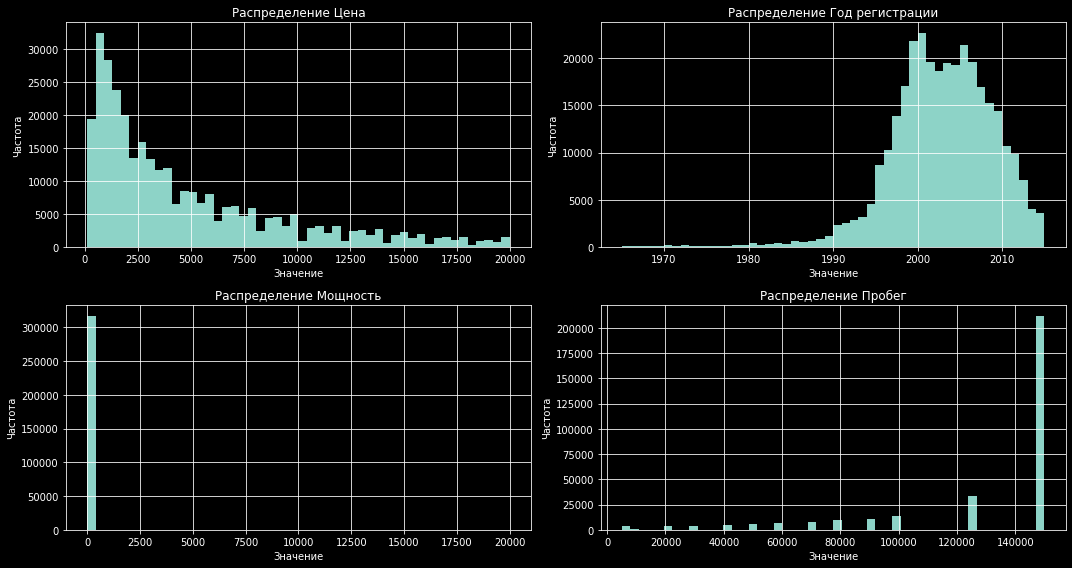

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
df[['price', 'registration_year', 'power', 'kilometer']].hist(ax=axes, bins=50)
plt.xlabel('Значение')
plt.ylabel('Частота')

column_names = ['Цена', 'Год регистрации', 'Мощность', 'Пробег']

for i, ax in enumerate(axes.flatten()):
    ax.set_title('Распределение {}'.format(column_names[i]))
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')

plt.tight_layout()

✅ Отлично

Осталось разобраться с признаком power  

Посмотрим на матрицу корреляции

Для начала уберем неинформативные и мешающие признаки и разделим на тренировочную и тестовую выборки


In [ ]:
# Removing uninformative signs
df = df.drop(['number_of_pictures', 'last_seen',
              'date_created', 'postal_code',
              'registration_month', 'date_crawled'], axis=1)

In [ ]:
# Checking
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


Так как данных у нас достаточно, можем разделить выборку 75/25

In [ ]:
# Divide into training and test samples
train, test = train_test_split(df, train_size=.75, random_state=RANDOM_STATE)

In [ ]:
# Check if the samples were divided correctly
print(f'Размер и доля тренировочной выборки: {train.shape[0]}, \
{round(train.shape[0] / df.shape[0], 2)} ')

print((f'Размер и доля тестовой выборки: {test.shape[0]}, \
{round(test.shape[0] / df.shape[0], 2)} '))

Размер и доля тренировочной выборки: 238430, 0.75 
Размер и доля тестовой выборки: 79477, 0.25 


Все отлично

In [ ]:
# Target dependencies according to phik
phik_corr_train = train.phik_matrix()
(
    phik_corr_train['price'].sort_values(ascending=False)
                      .to_frame()
                      .style.background_gradient(cmap=cm))

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


,price
price,1.000000
registration_year,0.696550
model,0.573868
brand,0.365090
repaired,0.348682
kilometer,0.314262
gearbox,0.298218
vehicle_type,0.275623
fuel_type,0.122944
power,0.000000


In [ ]:
phik_corr_train.style.background_gradient(cmap=cm)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.275623,0.696550,0.298218,0.000000,0.573868,0.314262,0.122944,0.365090,0.348682
vehicle_type,0.275623,1.000000,0.200624,0.552354,0.010470,0.900219,0.245354,0.322800,0.590685,0.401404
registration_year,0.696550,0.200624,1.000000,0.153681,0.012477,0.646722,0.440944,0.133192,0.389121,0.264811
gearbox,0.298218,0.552354,0.153681,1.000000,0.004667,0.626273,0.054870,0.437863,0.515562,0.427335
power,0.000000,0.010470,0.012477,0.004667,1.000000,0.007209,0.002586,0.010775,0.000000,0.011507
model,0.573868,0.900219,0.646722,0.626273,0.007209,1.000000,0.442880,0.377971,0.997915,0.300443
kilometer,0.314262,0.245354,0.440944,0.054870,0.002586,0.442880,1.000000,0.090032,0.276387,0.222937
fuel_type,0.122944,0.322800,0.133192,0.437863,0.010775,0.377971,0.090032,1.000000,0.212851,0.360746
brand,0.365090,0.590685,0.389121,0.515562,0.000000,0.997915,0.276387,0.212851,1.000000,0.145000
repaired,0.348682,0.401404,0.264811,0.427335,0.011507,0.300443,0.222937,0.360746,0.145000,1.000000


На данном этапе мы наблюдаем среднюю кореляцию - самую высокую, между ценой и годом регистрации, а также чуть слабее с признаком модель, остальные признаки показывают слабую корреляцию.  
  
Присутствует сильная зависимость признаков тип кузова и бренд с признаком модель, средняя с ценой, годом регистрации и коробкой передач  
Также у года регистрации и модели средняя зависимость, посмотрим как поведут себя модели с такой зависимостью между признаками и возможно придется устранять, если нам будет необходима интерпретируемость модели

Теперь посмотрим на признак power

In [ ]:
# Dependencies of the power attribute according to phik
(
    phik_corr_train['power'].sort_values(ascending=False)
                      .to_frame()
                      .style.background_gradient(cmap=cm))

,power
power,1.000000
registration_year,0.012477
repaired,0.011507
fuel_type,0.010775
vehicle_type,0.010470
model,0.007209
gearbox,0.004667
kilometer,0.002586
price,0.000000
brand,0.000000


По признаку power видим только очень слабую зависимость из за всего безобразия что с ним происходит, поэтому будем заполнять эти наблюдения объектами по модели и году, так как сам признак brand не особо информативен, в основном у каждого бренда свои модели, но тоже есть вероятность, что определенные модели выпускаются разными брендами, но характеристики у авто идентичные, возможно стоит сконкатенировать признаки vehicle_type, brand и model, тем самым частично избавиться от мультиколинеарности признаков


In [ ]:
train.query('30 > power or power > 650')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
156226,1950,unknown,2005,manual,0,touran,150000,petrol,volkswagen,unknown
312014,14495,bus,2013,manual,0,caddy,50000,other,volkswagen,no
221426,450,unknown,2015,other,0,unknown,70000,other,sonstige_autos,unknown
139763,4500,unknown,2000,auto,0,unknown,150000,petrol,sonstige_autos,unknown
92119,400,small,1995,manual,0,corsa,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
267102,800,wagon,2003,manual,0,passat,150000,other,volkswagen,yes
293033,2300,wagon,1999,manual,0,bora,150000,other,volkswagen,unknown
45810,220,unknown,1990,other,0,defender,5000,other,land_rover,unknown
61170,300,coupe,2000,manual,0,megane,150000,petrol,renault,unknown


Также стоит учитывать, что в этой выборке присутствуют и ретро машины и новые коллекционные, из-за них точность предсказания в дальнейшем будет страдать, так как их ценообразоваение сильно отличается от массмаркета  
Возможно стоит их разделить по группам, возможно даже предсказывать отдельно

In [ ]:
# Function for preprocessing the power feature
def make_power_great_again(data: pd.DataFrame) -> pd.DataFrame:
    """Preprocesses the 'power' feature based on human expertise.

    Args:
        data (pd.DataFrame): The dataset containing the 'power' feature to be processed.

    Returns:
        pd.DataFrame: The dataset with the processed 'power' feature.
        Prints statistics about changes in the dataset.
        Displays a histogram of the 'power' feature distribution in the dataset.

    Description:
        This function preprocesses the 'power' feature based on 'registration_year' and 'model' attributes.
        It calculates the median power for each combination of 'registration_year' and 'model' and
        replaces power values that are outside the range 30 < power < 650 with the calculated values.

    Example:
        >>> preprocessed_data = make_power_great_again(input_data)
    """
    # Power feature value recovery model
    data_shape = data.shape
    year_model_power = (
                            data.groupby(['registration_year', 'model'])['power']
                                .median()
                                .reset_index())

    # Rename the column, for a join with the main dataframe
    year_model_power = year_model_power.rename({'power': 'year_model_power'}, axis=1)
    # Join to the main dataframe
    data = data.merge(year_model_power, how='left', on=['registration_year', 'model'])
    # Replacing indexing values with predicted values
    data.loc[(data['power'] < 30) | (data['power'] > 650), 'power'] = data['year_model_power']
    # Deleting the 'year_model_power' column
    data = data.drop(['year_model_power'], axis=1)

    # Output statistics on changes
    print(f'Отброшено значений: {data.query("650 < power or power < 30").shape[0]}\n')
    # Removing the leftovers
    data = data.drop(data.query('650 < power or power < 30').index)

    print(f'Размер данных до обработки:    {data_shape}\n')
    print(f'Размер данных после обработки: {data.shape}\n')
    print(f'Пропущенных значений: {data.isna().sum().sum()}\n')
    print(data.isna().mean())
    print(f'\n Распределение признака power:\n')
    data['power'].hist(figsize=(13,5), bins=50);
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

    return data

Отброшено значений: 774

Размер данных до обработки:    (238430, 10)

Размер данных после обработки: (237656, 10)

Пропущенных значений: 0

price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
repaired             0.0
dtype: float64

 Распределение признака power:



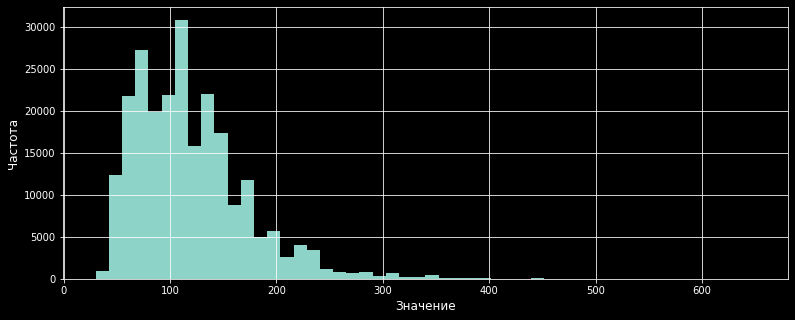

In [ ]:
# Preprocessing the train selection
train = make_power_great_again(train)

In [ ]:
# Check the result of processing
train.query('650 < power or power < 30')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired


Отлично!

---
Теперь повторим с тестовой выборкой

Тестовая выборка: 

Отброшено значений: 409

Размер данных до обработки:    (79477, 10)

Размер данных после обработки: (79068, 10)

Пропущенных значений: 0

price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
repaired             0.0
dtype: float64

 Распределение признака power:



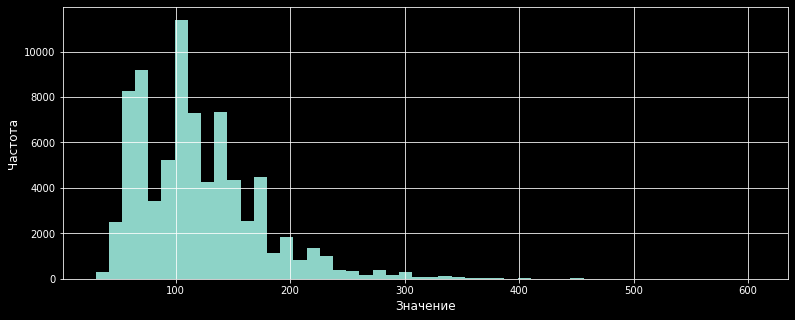

In [ ]:
# Preprocessing the test sample
print('Тестовая выборка:', '\n')
test = make_power_great_again(test)

Теперь еще раз взглянем на зависимости по нашим выборкам


In [ ]:
# Correlation of the training sample according to phik
phik_corr_train = train.phik_matrix()
phik_corr_train.style.background_gradient(cmap=cm)

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.275457,0.697295,0.297978,0.507020,0.578869,0.316105,0.121713,0.364964,0.347935
vehicle_type,0.275457,1.000000,0.197578,0.542086,0.471260,0.899906,0.246087,0.315539,0.589744,0.393281
registration_year,0.697295,0.197578,1.000000,0.141669,0.264962,0.646244,0.441756,0.126990,0.351027,0.263087
gearbox,0.297978,0.542086,0.141669,1.000000,0.466101,0.624111,0.055035,0.422538,0.513036,0.419568
power,0.507020,0.471260,0.264962,0.466101,1.000000,0.763271,0.095894,0.100353,0.544361,0.133277
model,0.578869,0.899906,0.646244,0.624111,0.763271,1.000000,0.439763,0.373522,0.997678,0.296870
kilometer,0.316105,0.246087,0.441756,0.055035,0.095894,0.439763,1.000000,0.091708,0.270879,0.225763
fuel_type,0.121713,0.315539,0.126990,0.422538,0.100353,0.373522,0.091708,1.000000,0.206441,0.354005
brand,0.364964,0.589744,0.351027,0.513036,0.544361,0.997678,0.270879,0.206441,1.000000,0.140094
repaired,0.347935,0.393281,0.263087,0.419568,0.133277,0.296870,0.225763,0.354005,0.140094,1.000000


Теперь видим, что признак power много значимее - средняя зависимость с целевым признаком и высокая с признаком модель,
  
Тип кузова, коробка передач и тип топлива имеют слабую зависимость с целевым признаком, возможно стоит исключить эти признаки, также избавимся от сильной зависимости между признаками vehicle_type и model и средней с признаком gearbox


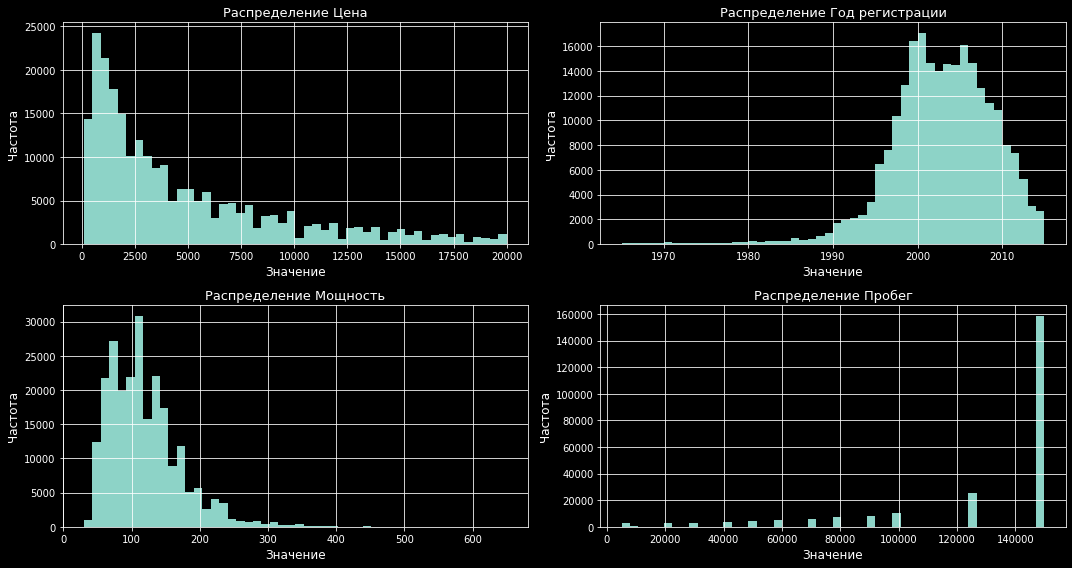

In [ ]:
# Distribution of train sampling features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
train.hist(ax=axes, bins=50)
plt.xlabel('Значение')
plt.ylabel('Частота')

column_names = ['Цена', 'Год регистрации', 'Мощность', 'Пробег']

for i, ax in enumerate(axes.flatten()):
    ax.set_title(
        'Распределение {}'.format(column_names[i]),
        fontsize=13)
    ax.set_xlabel('Значение', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)

plt.tight_layout()

Разделим признаки, категориальные признаки и целевой признак

In [ ]:
# Variables with features, categorical features and target
X = train.columns.drop('price')
y = ['price']
cat = ['vehicle_type','gearbox','fuel_type', 'model','brand', 'repaired']

In [ ]:
def display_shape(data: pd.DataFrame):
    """Get the dimensions and the first 5 rows of a dataset.

    Args:
        data (pd.DataFrame): The dataset for which statistics are needed.

    Returns:
        Tuple containing:
        - The dimensions (shape) of the dataset.
        - The first 5 rows of the dataset.

    Example:
        >>> data_dimensions, first_5_rows = display_shape(dataset)
    """
    print(f'Размерность фрейма: {data.shape}\n')
    print('Данные:\n')
    display(data.head())

In [ ]:
# Frame dimension by features
display_shape(train[X])

Размерность фрейма: (237656, 9)

Данные:



,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,sedan,2002,manual,150.0,e_klasse,150000,petrol,mercedes_benz,no
1,wagon,2008,manual,102.0,octavia,100000,petrol,skoda,no
2,sedan,1997,manual,101.0,a3,150000,petrol,audi,yes
3,sedan,1999,manual,75.0,golf,150000,petrol,volkswagen,no
4,sedan,2004,auto,204.0,e_klasse,150000,petrol,mercedes_benz,no


In [ ]:
# Frame dimension by target
display_shape(train[y])

Размерность фрейма: (237656, 1)

Данные:



,price
0,4500
1,6500
2,750
3,900
4,6500


In [ ]:
# Removing unnecessary variables
del date_group, date_grouped, more_power

Посмотрим сколько процентов от исходного датафрейма мы потеряли

In [ ]:
# Percentage of losses from the original data
percentage_losses(pd.concat([train, test], axis=0))

Процент потерь составил: 10.29%


### Промежуточный вывод:

Проведен первичный анализ и предобработка данных:  

+ Предобработали признаки для корректного исследования в обучении моделей,
+ Были выявлены дубликаты и пропуски в данных - данные максимально старались сохранить
+ Больше всего неприятностей доставил признак power - был заполнен после разделения выборок,  
для исключения утечки из тренировочной модели в тестовую
+ Исключены столбцы с данными - датами, некорректно выгрузились, необходимо изучить разработчикам
+ Такая же проблема со столбцом количество изображений, единственное значение в нем - 0
+ Отсутствующие значения столбцов коробка передач, тип топлива
+ Произведено логичное заполнение этих проблемных мест в датасете
+ Пропуски от 3 до 6% в столбцах тип кузова, тип топлива, модель, тип коробки передач были заполнены заглушками, которые уже присутствовали в выборке, без потери информативности, столбец repaired 17% также был заполнен заглушкой
+ Для дальнейшего исследования пришлось исключить 10% данных

Также:

+ Выявили проблемы со сбором данных с которыми мы обратимся к заказчику

## Обучение моделей

### Baseline

Создадим константную медианную модель для определения границы, ниже которой наши исследования не будут иметь смысла


In [ ]:
# Adding a constant prediction to the test sample
test['dummy'] = train['price'].median()

In [ ]:
test.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,dummy
0,9450,sedan,2005,auto,224.0,a6,150000,petrol,audi,no,2999.0
1,900,sedan,1998,manual,190.0,156,150000,petrol,alfa_romeo,no,2999.0
2,2400,wagon,2005,manual,116.0,primera,125000,petrol,nissan,no,2999.0
3,9000,wagon,2008,manual,105.0,transporter,150000,petrol,volkswagen,no,2999.0
4,4500,convertible,2005,manual,135.0,megane,150000,petrol,renault,no,2999.0


In [ ]:
# Loss metric of the constant dummy model
dummy_score_test = round(mean_squared_error(test[y], test['dummy'], squared=False), 4)

print("RMSE dummy-модели тестовой выборки", dummy_score_test)

RMSE dummy-модели тестовой выборки 4910.4619


Получили минимальное значение, ниже которого нам опускаться нельзя

---
Оптимизацию моделей будем производить на метрике MAE

### CatBoostRegressor

Люди мы простые, предобработали данные - запустили CatBoost

Сначала изучим как модель поведет себя на всех признаках и посмотрим какие из признаков ей больше важны


In [ ]:
(
    phik_corr_train['price'].sort_values(ascending=False)
                            .to_frame()
                            .style.background_gradient(cmap=cm))


,price
price,1.000000
registration_year,0.697295
model,0.578869
power,0.507020
brand,0.364964
repaired,0.347935
kilometer,0.316105
gearbox,0.297978
vehicle_type,0.275457
fuel_type,0.121713


Как видим, на нашу целевую переменную слабо влияет признак тип кузова,  
Выдвинем гипотезу, что при объединении признаков тип кузова и модель и бренд, увеличит зависимость и поможет в обучении


In [ ]:
# Additional sampling to test the hypothesis
train_concat = train.copy()
train_concat['model_vehtype'] = train_concat['model'].str.cat(train_concat['vehicle_type'], sep='_')
train_concat['model_vehtype_brand'] = train_concat['brand'].str.cat(train_concat['model_vehtype'], sep='_')
train_concat = train_concat.drop(['vehicle_type', 'model', 'brand', 'model_vehtype'], axis=1)

In [ ]:
# Features of the new selection
X_concat = train_concat.columns.drop(['price'])
cat_concat = ['gearbox', 'fuel_type', 'repaired', 'model_vehtype_brand']

In [ ]:
# Target-based dependencies in the new sample
phik_corr_concat = train_concat.phik_matrix()
(
    phik_corr_concat['price'].sort_values(ascending=False)
                            .to_frame()
                            .style.background_gradient(cmap=cm))

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


The number of unique values of variable model_vehtype_brand is large: 1829. Are you sure this is not an interval variable? Analysis for pairs of variables including model_vehtype_brand can be slow.


,price
price,1.000000
registration_year,0.697295
model_vehtype_brand,0.641098
power,0.507020
repaired,0.347935
kilometer,0.316105
gearbox,0.297978
fuel_type,0.121713


In [ ]:
# Transformed selection
phik_corr_concat.style.background_gradient(cmap=cm)

,price,registration_year,gearbox,power,kilometer,fuel_type,repaired,model_vehtype_brand
price,1.000000,0.697295,0.297978,0.507020,0.316105,0.121713,0.347935,0.641098
registration_year,0.697295,1.000000,0.141669,0.264962,0.441756,0.126990,0.263087,0.759430
gearbox,0.297978,0.141669,1.000000,0.466101,0.055035,0.422538,0.419568,0.733102
power,0.507020,0.264962,0.466101,1.000000,0.095894,0.100353,0.133277,0.798078
kilometer,0.316105,0.441756,0.055035,0.095894,1.000000,0.091708,0.225763,0.515088
fuel_type,0.121713,0.126990,0.422538,0.100353,0.091708,1.000000,0.354005,0.643965
repaired,0.347935,0.263087,0.419568,0.133277,0.225763,0.354005,1.000000,0.469879
model_vehtype_brand,0.641098,0.759430,0.733102,0.798078,0.515088,0.643965,0.469879,1.000000


In [ ]:
# Look at the original training sample
phik_corr_train.style.background_gradient(cmap=cm)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.275457,0.697295,0.297978,0.507020,0.578869,0.316105,0.121713,0.364964,0.347935
vehicle_type,0.275457,1.000000,0.197578,0.542086,0.471260,0.899906,0.246087,0.315539,0.589744,0.393281
registration_year,0.697295,0.197578,1.000000,0.141669,0.264962,0.646244,0.441756,0.126990,0.351027,0.263087
gearbox,0.297978,0.542086,0.141669,1.000000,0.466101,0.624111,0.055035,0.422538,0.513036,0.419568
power,0.507020,0.471260,0.264962,0.466101,1.000000,0.763271,0.095894,0.100353,0.544361,0.133277
model,0.578869,0.899906,0.646244,0.624111,0.763271,1.000000,0.439763,0.373522,0.997678,0.296870
kilometer,0.316105,0.246087,0.441756,0.055035,0.095894,0.439763,1.000000,0.091708,0.270879,0.225763
fuel_type,0.121713,0.315539,0.126990,0.422538,0.100353,0.373522,0.091708,1.000000,0.206441,0.354005
brand,0.364964,0.589744,0.351027,0.513036,0.544361,0.997678,0.270879,0.206441,1.000000,0.140094
repaired,0.347935,0.393281,0.263087,0.419568,0.133277,0.296870,0.225763,0.354005,0.140094,1.000000


Мы убрали очень сильную зависимость между признаками и пришли к средней - высокой, изучим поможет ли нам это при обучении


In [ ]:
# the wall-time output function of the algorithm
def show_time(time_set, mode: int):
    """Display wall-time execution duration of an algorithm.

    Args:
        time_set: The start time.
        mode (int): A flag to determine the output:
            1 - Training time.
            2 - Prediction time.
            3 - Data transformation time.

    Returns:
        float: The execution time in seconds.

    Example:
        >>> elapsed_time = show_time(start_time, 1)
    """
    time_complete = time.time() - time_set
    if mode == 1:
        print(
            "\nВремя обучения модели:", \
            round(time_complete, 3), "секунд\n")
    if mode == 2:
        print(
            "\nВремя предсказания модели:", \
            round(time_complete, 3), "секунд\n")
    if mode == 3:
        print(
            "\nВремя трансформации данных:", \
            round(time_complete, 3), "секунд\n")
    return time_complete

Для оценки модели будем использовать встроенные методы sklearn

In [ ]:
# Parameter Grid
parametrs = {
    'cat_features': cat,
    'max_depth': 13,
    'early_stopping_rounds': 50,
    'eval_metric': 'MAE',
    'iterations': 200,
    'learning_rate': 0.41,
    'verbose': 100,
    'random_seed': RANDOM_STATE,
}
# Catbust model on all features
cat_model = CatBoostRegressor(**parametrs)

In [ ]:
%%time
# Using cross-validation, we get the metric of the model
scores_cat = cross_val_score(
                          cat_model, train[X],
                          train[y].values.ravel(),
                          cv=3, scoring='neg_mean_absolute_error')
# Converting MAE values from negative to positive
scores_cat = -scores_cat

# Averaging the metric
scores_cat_val = scores_cat.mean()

# Output of the MSE metric
print("MAE на кросс-валидации:", scores_cat_val)

0:	learn: 2449.8067800	total: 1.06s	remaining: 3m 31s
100:	learn: 826.0673727	total: 1m 31s	remaining: 1m 29s
199:	learn: 747.0779802	total: 3m 7s	remaining: 0us
0:	learn: 2445.4475314	total: 897ms	remaining: 2m 58s
100:	learn: 829.6096926	total: 1m 32s	remaining: 1m 30s
199:	learn: 755.4859601	total: 3m 6s	remaining: 0us
0:	learn: 2436.9440809	total: 748ms	remaining: 2m 28s
100:	learn: 822.1167741	total: 1m 29s	remaining: 1m 27s
199:	learn: 752.0078496	total: 3m 2s	remaining: 0us
MAE на кросс-валидации: 974.3169613936097
CPU times: user 9min 18s, sys: 1.16 s, total: 9min 19s
Wall time: 9min 26s


In [ ]:
# We mark the time and train the model
time_start = time.time()
cat_model.fit(train[X], train[y])
time_fit_cat = show_time(time_start, 1)

0:	learn: 2452.1317519	total: 1.26s	remaining: 4m 9s
100:	learn: 840.2146194	total: 2m	remaining: 1m 58s
199:	learn: 774.0256456	total: 3m 57s	remaining: 0us

Время обучения модели: 240.259 секунд



In [ ]:
cat_train_score = cat_model.best_score_['learn']['MAE']
print("MAE на тренировочной выборке:", cat_train_score)

MAE на тренировочной выборке: 774.0256456178233


In [ ]:
# Mark the prediction time on train
time_start = time.time()
cat_model.predict(train[X])
cat_pred_time = show_time(time_start, 2)


Время предсказания модели: 1.806 секунд



Проверим нашу гипотезу о сконкатенированных признаках

In [ ]:
# Parameter Grid
parametrs = {
    'cat_features': cat_concat,
    'max_depth': 13,
    'early_stopping_rounds': 50,
    'eval_metric': 'MAE',
    'iterations': 200,
    'learning_rate': 0.40,
    'verbose': 100,
    'random_seed': RANDOM_STATE,
}
# The catbust model on the configured features
cat_model_concat = CatBoostRegressor(**parametrs)

In [ ]:
%%time
# Using cross-validation, we get the metric of the model
scores_cat_concat = cross_val_score(
                          cat_model_concat, train_concat[X_concat],
                          train_concat[y].values.ravel(),
                          cv=3, scoring='neg_mean_absolute_error')

# Converting MAE values from negative to positive
scores_cat_concat = -scores_cat_concat

# Averaging the metric
scores_cat_concat = scores_cat_concat.mean()

# Output of the MAE metric
print("MAE на кросс-валидации:", scores_cat_concat)

0:	learn: 2532.4650182	total: 354ms	remaining: 1m 10s
10:	learn: 1159.1346668	total: 4.94s	remaining: 1m 24s
20:	learn: 1086.0320283	total: 10.1s	remaining: 1m 26s
30:	learn: 1053.4922070	total: 15.2s	remaining: 1m 23s
40:	learn: 1026.4879193	total: 20.5s	remaining: 1m 19s
50:	learn: 1001.7439780	total: 25.6s	remaining: 1m 14s
60:	learn: 980.5322909	total: 30.8s	remaining: 1m 10s
70:	learn: 965.8621755	total: 36.1s	remaining: 1m 5s
80:	learn: 953.2101148	total: 41.3s	remaining: 1m
90:	learn: 943.5647643	total: 46.5s	remaining: 55.7s
100:	learn: 925.8829620	total: 51.7s	remaining: 50.7s
110:	learn: 913.8704713	total: 56.9s	remaining: 45.7s
120:	learn: 904.5609932	total: 1m 2s	remaining: 40.8s
130:	learn: 895.6354341	total: 1m 7s	remaining: 35.6s
140:	learn: 885.5526427	total: 1m 12s	remaining: 30.5s
150:	learn: 876.0446305	total: 1m 18s	remaining: 25.5s
160:	learn: 868.1535319	total: 1m 23s	remaining: 20.3s
170:	learn: 858.2955770	total: 1m 28s	remaining: 15.1s
180:	learn: 849.7150252	t

Наша гипотеза не подтвердилась, объединение признаков только ухудшило метрику, но ускорило обучение

In [ ]:
%%time
# We mark the time and train the model
time_start = time.time()
cat_model_concat.fit(train_concat[X_concat], train_concat[y])
time_fit_cat_conc = show_time(time_start, 1)

0:	learn: 2501.6510049	total: 889ms	remaining: 2m 56s
10:	learn: 1150.0937413	total: 7.56s	remaining: 2m 9s
20:	learn: 1092.3702408	total: 14.7s	remaining: 2m 5s
30:	learn: 1061.9299280	total: 21.5s	remaining: 1m 57s
40:	learn: 1027.4795892	total: 29s	remaining: 1m 52s
50:	learn: 1004.2380372	total: 36.5s	remaining: 1m 46s
60:	learn: 985.2349310	total: 44.3s	remaining: 1m 40s
70:	learn: 975.5472783	total: 51.7s	remaining: 1m 33s
80:	learn: 961.8702778	total: 59.1s	remaining: 1m 26s
90:	learn: 948.2152253	total: 1m 6s	remaining: 1m 20s
100:	learn: 936.5900733	total: 1m 14s	remaining: 1m 12s
110:	learn: 928.5115319	total: 1m 21s	remaining: 1m 5s
120:	learn: 919.2988036	total: 1m 29s	remaining: 58.3s
130:	learn: 911.8473999	total: 1m 36s	remaining: 51.1s
140:	learn: 905.4459648	total: 1m 44s	remaining: 43.8s
150:	learn: 897.4504211	total: 1m 52s	remaining: 36.5s
160:	learn: 890.2850704	total: 2m	remaining: 29.1s
170:	learn: 882.9342147	total: 2m 7s	remaining: 21.6s
180:	learn: 876.7762120

Наша гипотеза не подтвердилась, объединение признаков только ухудшило метрику

In [ ]:
# Importance of features on complete data
(
    cat_model.get_feature_importance(prettified=True)
             .style.background_gradient(cmap=cm))

,Feature Id,Importances
0,registration_year,30.765019
1,power,17.075521
2,brand,14.898195
3,vehicle_type,11.753539
4,kilometer,8.771232
5,model,7.582586
6,repaired,4.716628
7,gearbox,3.818823
8,fuel_type,0.618458


In [ ]:
# Importance of features on concatenated features
(
    cat_model_concat.get_feature_importance(prettified=True)
             .style.background_gradient(cmap=cm))

,Feature Id,Importances
0,registration_year,32.919636
1,power,24.111722
2,model_vehtype_brand,22.048990
3,kilometer,10.144555
4,gearbox,5.864091
5,repaired,4.093480
6,fuel_type,0.817526


Как мы видим, меньше всего значит для кэтбуста признак fuel_type, но мы не можем его исключить, так как один из типов топлива, а именно - электричество, имеет большую среднюю стоимость, но таких наблюдений не так много


---

### RandomForestRegressor

Посмотрим на модель случайного леса

In [ ]:
# Identification of features that require different transformations
categorical_features = train[cat].columns
numerical_features = ['registration_year', 'power', 'kilometer']

categorical_transformer = TargetEncoder()
numerical_transformer = MinMaxScaler()

# Creating a Column Transformer to apply different transformations to different features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)])

# Grid of parameters for a random forest
parametrs = {
    'random_state': 42,
    'n_estimators': 167,
    'min_samples_split': 4,
    'min_samples_leaf': 10,
    'max_depth': 18,
}
# Random Forest model
rf_model = RandomForestRegressor(**parametrs)

In [ ]:
# Now we need to convert the data before training and time it
time_start = time.time()
train_rf = preprocessor.fit_transform(train[X], train[y])
rf_trans_time = show_time(time_start, 3)


Время трансформации данных: 1.906 секунд



In [ ]:
%%time
# Using cross-validation, we get the metric of the model
scores_rf = cross_val_score(
                          rf_model, train_rf,
                          train[y].values.ravel(),
                          cv=3, scoring='neg_mean_absolute_error')

# Converting MAE values from negative to positive
rf_val_score = -scores_rf

# Averaging the metric
rf_val_score = rf_val_score.mean()

# Output of the MAE metric
print("MAE на кросс-валидации:", rf_val_score)

MAE на кросс-валидации: 1005.3751703050283
CPU times: user 2min 34s, sys: 476 ms, total: 2min 34s
Wall time: 2min 35s


In [ ]:
%%time
# We train the model and mark the time
time_start = time.time()
rf_model.fit(train_rf, train[y].values.ravel())
rf_fit_time = show_time(time_start, 1)

# We mark the prediction time on train
time_start = time.time()
rf_model.predict(train_rf)
rf_pred_time = show_time(time_start, 2)


Время обучения модели: 79.136 секунд


Время предсказания модели: 6.776 секунд

CPU times: user 1min 25s, sys: 168 ms, total: 1min 25s
Wall time: 1min 25s


---

### LightGBMRegressor

Теперь запустим LightGBM  
Необходимо преобразовать тип категориальных признаков

In [ ]:
# Conversion of categorical features to the 'category' type of the training sample
time_start = time.time()
train_lgbm = train.copy()
train_lgbm[categorical_features] = train_lgbm[categorical_features].astype('category')
lgbm_trans_train_time = show_time(time_start, 3)

# Conversion of categorical features to the 'category' type of the test sample
test_lgbm = test.copy()
test_lgbm[categorical_features] = test_lgbm[categorical_features].astype('category')


Время трансформации данных: 0.161 секунд



In [ ]:
%%time
# Using cross-validation, we will get a metric for the model
# LGBM Parameter Grid
parametrs = {
#   'boosting_type': 'dart',
    'learning_rate': 0.11,
#   'max_depth': 11,
    'n_estimators': 1000,
    'num_leaves': 31,
    }
lgbm_model = LGBMRegressor(**parametrs)

# Evaluation of the model by cross-validation
scores = cross_val_score(lgbm_model, train_lgbm[X],
                         train_lgbm[y].values.ravel(),
                         cv=3, scoring='neg_mean_absolute_error')

# Converting MAE values from negative to positive
lgbm_val_score = -scores

# Averaging the metric
lgbm_val_score = lgbm_val_score.mean()

# Output of the MAE metric
print("MAE на кросс-валидации:", lgbm_val_score)

MAE на кросс-валидации: 948.8064249204461
CPU times: user 2min 13s, sys: 906 ms, total: 2min 13s
Wall time: 2min 15s


In [ ]:
%%time
# Training the model
time_start = time.time()
lgbm_model.fit(train_lgbm[X], train_lgbm[y].values.ravel())
lgbm_fit_time = show_time(time_start, 1)

# We mark the prediction time on train
time_start = time.time()
lgbm_model.predict(train_lgbm[X])
lgbm_pred_time = show_time(time_start, 2)


Время обучения модели: 45.401 секунд


Время предсказания модели: 26.861 секунд

CPU times: user 1min 11s, sys: 363 ms, total: 1min 11s
Wall time: 1min 12s


### Промежуточный вывод:

Было проведено исследование трех моделей, также получили метрики RMSE кросс-валидацией:
+ CatBoostRegressor - не требовал преобразований, получил хорошую метрику, но достаточно долго происходило обучение
+ RandomForestRegressor - провели преобразование категориальных признаков с помощью TargetEncoder, количественных - MinMaxScaler, достаточно быстрое обучение и предсказание, по времени выигрывает именно эта модель, метрика хуже, чем у предыдущей модели
+ LightGBM - преобразовали категориальные признаки путем изменения типа на category, получилось достаточно быстрое обучение, но немного дольше, чем у модели Случайного Леса и довольной хорошее качество, ошибка меньше чем у двух предыдущих моделей

Также:

+ Проверили гипотезу об объединении признаков brand model и vehicle_type, в связи с этими преобразованиями метрика на порядок поднялась, мы отвергли эту гипотезу

В следующем блоке изучим результаты полученные в исследовании...

## Анализ моделей

Соберем все данные в таблицу

In [ ]:
# dataframe with results
df_result = pd.DataFrame({
    'model': [
        'CatBoostRegressor',
        'RandomForestRegressor',
        'LightGBMRegressor',],
    'MAE_valid': [
        scores_cat_val,
        rf_val_score,
        lgbm_val_score,
    ],
    'fit_time': [
        time_fit_cat,
        rf_fit_time,
        lgbm_fit_time,
    ],
    'pred_time': [
        cat_pred_time,
        rf_pred_time,
        lgbm_pred_time,
    ],
    'train_trans_time': [
        'included_fit',
        rf_trans_time,
        lgbm_trans_train_time,],

    'total_time': [
        time_fit_cat + cat_pred_time,
        rf_fit_time + rf_trans_time + rf_pred_time,
        lgbm_fit_time + lgbm_trans_train_time + lgbm_pred_time,
    ],
    })

In [ ]:
# Look at the result
(
    df_result.sort_values(by=['MAE_valid', 'fit_time'])
             .style.background_gradient(cmap=cm))

,model,MAE_valid,fit_time,pred_time,train_trans_time,total_time
2,LightGBMRegressor,948.806425,45.400664,26.861144,0.160924,72.422732
0,CatBoostRegressor,974.316961,240.259488,1.805624,included_fit,242.065113
1,RandomForestRegressor,1005.375170,79.135997,6.775830,1.906191,87.818018


Лучше всех себя показала модель LGBM с самыми малыми временными затратами и лучшим результатом, дольше всех обучалась модель CatBoost даже с учетом преобразований.  
Случайный лес показал метрику хуже, чем предыдущие, но скорость предсказания это его преимущество  
Нашим фаворитом стала модель LGBM - золотая середина нашего исследования - лучшее качество,  
минимальное время обучения, но большое время предсказания - общее время на модель меньше остальных  
Поэтому предскажем на тестовой выборке именно этой моделью, для получения финальных значений


### Финальный результат

In [ ]:
# lgbm prediction on a test sample
time_start = time.time()
final_res = lgbm_model.predict(test_lgbm[X])
lgbm_final_pred_time = show_time(time_start, 2)

# RMSE
final_score = round(mean_squared_error(test_lgbm[y], final_res, squared=False), 3)

print('Метрика RMSE, Baseline-model на тестовой выборке:     ', dummy_score_test)
print('Финальная метрика RMSE, результат на тестовой выборке:', final_score)


Время предсказания модели: 9.125 секунд

Метрика RMSE, Baseline-model на тестовой выборке:      4910.4619
Финальная метрика RMSE, результат на тестовой выборке: 1524.93


In [ ]:
# Calculate how many percent the final metric exceeded the baseline
improvement_percentage = (dummy_score_test - final_score) / dummy_score_test * 100

print(f'Финальная метрика превзошла бейзлайн на {improvement_percentage:.2f}%')

Финальная метрика превзошла бейзлайн на 68.95%


## Вывод

Мы проделали огромную работу, а именно:  
+ Провели объемные анализ и предобработку данных,  
    + Выявили проблемные места при сборе данных, отметили в исследовании
+ Определили необходимые признаки и исключили неинформативные,
+ Выбрали три модели для исследования:
  + CatBoostRegressor
  + RandomForestRegressor
  + LightGBMRegressor
+ Для каждой модели обработали данные:
  + CatBoostRegressor - самостоятельно обрабатывает данные, поэтому для него никакой предварительной обработки не было, кроме указания категориальных признаков
  + RandomForestRegressor - преобразовали категориальные признаки с помощью TargetEncoder, а количественные - MinMaxSaler
  + Для LGBM изменили тип категориальных признаков на category
+ Обучили модели и получили их время обучения:
  + Для CatBoost это 240 секунд
  + Для RandomForest это 80 секунд
  + Для LGBM это 45 секунд
+ Оптимизировали модели по метрике MAE на кросс-валидации:
  + CatBoost - 974.32, время предсказания на тренировочной выборке - 1.82
  + RandomForest - 1005.38, время предсказания на тренировочной выборке - 7.32
  + LGBM - 948.81, время предсказания на тренировочной выборке - 28.42
+ Определили лучшую модель - LightGBMRegressor
+ С помощью нашей финальной модели получили на тестовой выборке метрику и  время предсказания:
  + RMSE: 1524.93
  + Время предсказания: 9.125 секунд
  + Наша модель превзошла бейзлайн метрику на 68.95%
  
Можем сказать что с достаточной точностью можем предсказать стоимость авто и задача решена